# Loan recommendation using Collaborative Filtering

The rating data is in loan_rating.csv, containing lender_id, loan_id, rating. Rating can be from 0-10.

In [1]:
import locale
import csv

locale.setlocale(locale.LC_ALL, 'de_DE')


'de_DE'

In [26]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
#locale.setlocale(locale.LC_ALL, 'deu_deu')

os.chdir(r"C:\Users\User\Desktop\2019 Spring\Big Data\Week 6")

loan_rating_df = pd.read_csv("loan_rating.csv",header =0)
loan_rating_df.head()

,lender_id,loan_id,rating
0,0,0,3
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,2


Use surprise package to read rating data in, train and test the model

In [47]:

from surprise import Reader, Dataset 

loan_rating_df = pd.read_csv("loan_rating.csv")
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(loan_rating_df[['lender_id', 'loan_id', 'rating']], reader)
data

In [33]:
reader

In [8]:
from surprise import NMF, evaluate
from surprise import accuracy
from surprise.model_selection import train_test_split

algo = NMF()
trainset, testset = train_test_split(data, test_size=.3)

output = algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 3.5915


3.591514001373734

In [39]:
predictions[:10]

[Prediction(uid=1, iid=65983, r_ui=9.0, est=0.8125834011513249, details={'was_impossible': False}),
 Prediction(uid=5, iid=39952, r_ui=0.0, est=0, details={'was_impossible': False}),
 Prediction(uid=9, iid=79154, r_ui=0.0, est=2.6958901194008122, details={'was_impossible': False}),
 Prediction(uid=9, iid=82976, r_ui=0.0, est=3.2796911141269494, details={'was_impossible': False}),
 Prediction(uid=8, iid=19578, r_ui=0.0, est=0, details={'was_impossible': False}),
 Prediction(uid=8, iid=46513, r_ui=0.0, est=0.6056206830346944, details={'was_impossible': False}),
 Prediction(uid=7, iid=74934, r_ui=5.0, est=0.2335574905556248, details={'was_impossible': False}),
 Prediction(uid=5, iid=20080, r_ui=0.0, est=0.3556784053603952, details={'was_impossible': False}),
 Prediction(uid=2, iid=79033, r_ui=0.0, est=3.4558038328903127, details={'was_impossible': False}),
 Prediction(uid=3, iid=66660, r_ui=0.0, est=2.003335292471313, details={'was_impossible': False})]

In [52]:
pred_loans[:,1][::-1]

array([0.5600979 , 0.28280641, 0.64195663, ..., 1.72347369, 0.        ,
       0.8125834 ])

In [53]:
pred_loans[pred_top_loans_index, 0]

array([ 34278.,  90820., 103504.,   6390.,   3051.,  51248.,    145.,
        60090.,  97985.,  58183.])

In [54]:
import numpy as np

pred_loans = np.array([[pred.iid,pred.est] for pred in predictions if pred.uid == 1])
pred_top_loans_index = np.argsort(pred_loans[:,1])[::-1][:10]
pred_top_loans = pred_loans[pred_top_loans_index, 0]
pred_top_loans

array([ 34278.,  90820., 103504.,   6390.,   3051.,  51248.,    145.,
        60090.,  97985.,  58183.])

In [15]:
loan_df = pd.read_csv("loan.csv",header = 0)
loan_df.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
0,5000,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500,60 months,15.27,0.0,RENT,30000.0,car,GA,1.00,0.0,9.4,4.0,1,12.0,verified
2,2400,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified
3,10000,36 months,13.49,10.0,RENT,49200.0,other,CA,20.00,0.0,21.0,37.0,0,15.0,verified
4,5000,36 months,7.90,3.0,RENT,36000.0,wedding,AZ,11.20,0.0,28.3,12.0,0,7.0,verified


In [21]:
info = loan_df.loc[1,:]
info

loan_amnt                     2500
term                     60 months
int_rate                     15.27
emp_length                       0
home_ownership                RENT
annual_inc                   30000
purpose                        car
addr_state                      GA
dti                              1
delinq_2yrs                      0
revol_util                     9.4
total_acc                        4
bad_loan                         1
longest_credit_length           12
verification_status       verified
Name: 1, dtype: object

Now give recommendations

In [18]:
top = 3

lenders = loan_rating_df['lender_id'].unique()
n_lenders = len(lenders)
loans = loan_rating_df['loan_id'].unique()
n_loans = len(loans)
Y = np.empty([n_loans, n_lenders])
limit = 100
Y = Y[:limit,:]
R = (Y != -1)
R = R.astype(float)
for j in range(n_lenders):
    # get top 3 loans
    # iid is the loan_id 
    pred_loans = np.array([[pred.iid,pred.est] for pred in predictions if pred.uid == j])
    pred_top_loans_index = np.argsort(pred_loans[:,1])[::-1][:top]
    pred_top_loans = pred_loans[pred_top_loans_index, :]
     
    for i in range(limit):
        loan = pred_top_loans[i,:]
        info = loan_df.loc[loan[0],:]
        print('Predicted rating %.1f for loan of  %s  for %s with %s purpose at %.1f percent interest\n' %
        (pred_top_loans[i][1], locale.currency(np.float(info.loan_amnt),grouping=True), info.term, info.purpose, np.float(info.int_rate)))

Predicted rating 10.0 for loan of  15.000,00 €  for 36 months with debt_consolidation purpose at 13.0 percent interest

Predicted rating 10.0 for loan of  12.000,00 €  for 36 months with debt_consolidation purpose at 7.9 percent interest

Predicted rating 10.0 for loan of  18.000,00 €  for 36 months with debt_consolidation purpose at 11.0 percent interest



IndexError: index 3 is out of bounds for axis 0 with size 3

In [19]:
n_lenders = len(loan_rating_df['lender_id'].unique())
n_loans = len(loan_rating_df['loan_id'].unique())

In [20]:
loan_rating_df[loan_rating_df['loan_id'] == 100][loan_rating_df['lender_id'] == 1][['rating']].values[0,0]

0

Now a recommender system model from scratch

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np
import random
import csv
from sklearn.model_selection import train_test_split
import locale # for currency formatting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

loan_rating_df = pd.read_csv("loan_rating.csv",header =0)
loan_rating_df.head()

,lender_id,loan_id,rating
0,0,0,3
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,2


In [23]:
lenders = loan_rating_df['lender_id'].unique()
n_lenders = len(lenders)
loans = loan_rating_df['loan_id'].unique()
n_loans = len(loans)
Y = np.empty([n_loans, n_lenders])

for loan in loans[:limit]:
    for lender in lenders:
        rating = loan_rating_df[loan_rating_df['loan_id'] == loan][loan_rating_df['lender_id'] == lender]['rating']
        if len(rating) == 0:
            Y[loan,lender] = -1
        else:
            Y[loan,lender] = rating.values[0]
        
        Y = Y.astype(float)

# use just part of Y (like, 100 loans)
limit = 100
Y = Y[:limit,:]
R = (Y != -1)
R = R.astype(float)

In [24]:
loan_df = pd.read_csv("loan.csv",header =0)
loan_df.head()
info = np.array(loan_df)[:limit,:]

Starting here write your own code in these functions

In [56]:
def costFun(param, Y, r, n_lenders, n_loans, n_features, lamba):

    X = param[0:(n_loans * n_features)].reshape(n_loans,n_features)
    Theta = param[0:(n_features * n_lenders)].reshape(n_features , n_lenders)
    x = np.dot(X,np.transpose(Theta))
    y = np.nansum(np.square(x-Y)/2 * r) 
    reg1 = (lamba/2) * np.sum(np.square(Theta))
    reg2 = (lamba/2) * np.sum(np.square(X))
    
    return y+reg1+reg2

def cost_grad(param, Y, r, n_lenders, n_loans, n_features, lamba):    
    X = param[0:(n_loans * n_features)].reshape(n_loans,n_features)
    Theta = param[0:(n_features * n_lenders)].reshape(n_features, n_lenders)
    x = np.dot(X,np.transpose(Theta))

    X_grad = np.dot(((x - Y) * r), Theta) + lamba * X
    Theta_grad = np.dot(np.transpose((x - Y) * r),X) + lamba * Theta
    
    grad = X_grad, Theta_grad
    return grad

In [63]:
def optimizeCost(param, Y, r, n_lenders, n_loans, n_features, lamba, step, maxrun):
    # Write your code here
    cost_range =[]
    for i in range(maxrun):
        cost = costFun(param, Y, r, n_lenders, n_loans, n_features, lamba)
        cost_range.append(cost) 
        X = param[0:(n_loans * n_features)].reshape(n_loans,n_features)
        Theta = param[0:(n_features * n_lenders)].reshape(n_features, n_lenders) 
        X_grad, Theta_grad = cost_grad(param, Y, r, n_lenders, n_loans, n_features, lamba)  
        X -= step * X_grad

        Theta -= step * Theta_grad
      
        param = np.concatenate((X.reshape(n_loans * n_features, 1, order = "F"),
                             Theta.reshape(n_lenders * n_features, 1, order = "F")))
        param = np.squeeze(param)


    return param,cost_range

In [72]:
    j1 = np.dot(X,np.transpose(Theta))
    j2 = np.square(np.dot(X,np.transpose(Theta))-Y)
    j3 = np.square(np.dot(X,np.transpose(Theta))-Y)/2
    j4 =  np.square(np.dot(X,np.transpose(Theta))-Y)/2 * r
    j5 = np.nansum(np.square(np.dot(X,np.transpose(Theta))-Y)/2 * r) 

array([[-0.13756339,  1.32990777,  0.6293441 ,  0.64438289,  0.80708717,
        -0.25269124,  0.36464084,  0.55388743,  0.21092193,  0.83388524],
       [ 1.29914981,  0.31244847, -0.45231679,  1.11383908,  0.54807608,
         0.73337848,  0.85142714,  1.48848142,  0.19166116,  0.10126919],
       [ 0.62009633,  0.03446035,  0.50317662, -0.10761707,  0.77748693,
         0.6329411 ,  0.21544495,  0.14882401,  0.8730041 ,  0.8914016 ],
       [ 0.64780586,  0.48770854, -0.21887506,  0.52074396,  0.12959803,
         0.49023321,  0.34827491, -0.07571747,  1.57494132,  0.57824096],
       [ 0.79117244,  0.49975926,  0.35090691,  0.34205613,  0.57202861,
         0.35216858, -0.03950417,  1.02392643, -0.01093472,  0.01036171],
       [-0.25834962,  0.56373885,  1.19230322,  0.25099563,  0.63480446,
         0.81107842,  0.63710853,  0.89613273,  0.61537246,  0.22460817],
       [ 0.34801086,  0.50622956,  0.42914297,  0.08682116,  0.8581139 ,
        -0.18045366,  0.35147527,  0.49155952

In [78]:
def costFun(param, Y, r, n_lenders, n_loans, n_features, lamba):
    
#X-loaners theta-lenders
    X = param[0:(n_loans * n_features)].reshape(n_loans,n_features)
    Theta = param[0:(n_features * n_lenders)].reshape(n_features , n_lenders)
    y = np.nansum(np.square(np.dot(X,np.transpose(Theta))-Y)/2 * r) 

    #Regularization for lender and loaner
    regX = (lamba/2) * np.sum(np.square(X))
    regT = (lamba/2) * np.sum(np.square(Theta))
    
    return y+regT+regX
   
    
    
    
def cost_grad(param, Y, r, n_lenders, n_loans, n_features, lamba):
    
#X-loaners theta-lenders
    X = param[0:(n_loans * n_features)].reshape(n_loans,n_features)
    Theta = param[0:(n_features * n_lenders)].reshape(n_features, n_lenders)

#Gradient Cost Equation
    X_grad = np.dot(((np.dot(X,np.transpose(Theta)) - Y) * r), Theta) + lamba * X
    Theta_grad = np.dot(np.transpose((np.dot(X,np.transpose(Theta)) - Y) * r),X) + lamba * Theta
    
    grad = X_grad, Theta_grad
    
    return grad
    
def optimizeCost(param, Y, r, n_lenders, n_loans, n_features, lamba, step, maxrun):
    # Write your code here
    
    return param,cost_range




In [77]:
np.concatenate((X.reshape(n_loans * n_features, 1, order = "F"),
                             Theta.reshape(n_lenders * n_features, 1, order = "F")))

array([[-0.13756339],
       [ 1.32990777],
       [ 0.6293441 ],
       ...,
       [ 0.68605625],
       [ 0.31206275],
       [-0.09981872]])

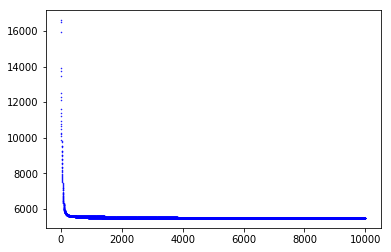


Top 3 recommendations for lender 1:

Predicted rating 5.2 for loan of  3.000,00 €  for 36 months with car purpose at 18.6 percent interest

Predicted rating 4.8 for loan of  17.500,00 €  for 60 months with credit_card purpose at 17.3 percent interest

Predicted rating 3.8 for loan of  6.000,00 €  for 36 months with major_purchase purpose at 11.7 percent interest


Top 3 recommendations for lender 2:

Predicted rating 7.5 for loan of  5.000,00 €  for 36 months with wedding purpose at 7.9 percent interest

Predicted rating 6.8 for loan of  24.000,00 €  for 36 months with debt_consolidation purpose at 10.7 percent interest

Predicted rating 6.8 for loan of  6.000,00 €  for 36 months with medical purpose at 11.7 percent interest


Top 3 recommendations for lender 3:

Predicted rating 4.9 for loan of  10.000,00 €  for 60 months with debt_consolidation purpose at 10.7 percent interest

Predicted rating 4.6 for loan of  17.675,00 €  for 60 months with debt_consolidation purpose at 14.7 perce

In [79]:
n_lenders = np.size(Y, 1)
n_loans = np.size(Y, 0)
n_features = 10
# Initialization
X = np.random.normal(loc = 0.0, scale = 1.0, size = (n_loans, n_features))
Theta = np.random.normal(loc = 0.0, scale = 1.0, size = (n_lenders,n_features))
init_param = np.concatenate((X.reshape(n_loans * n_features, 1, order = "F"),
                             Theta.reshape(n_lenders * n_features, 1, order = "F")))
init_param = np.squeeze(init_param)

# Optimization
lamba = 10
maxrun = 10000
step = 0.001

param,cost_range = optimizeCost(init_param, Y, R, n_lenders, n_loans, \
                     n_features, lamba, step, maxrun)
# now plot the cost
plt.plot(cost_range,"b.",markersize=1,label="Cost") # note: this is 0-based
plt.show()
    
# Extract X and Theta from param vector
X = param[0:(n_loans * n_features)]
Theta = param[(n_loans * n_features):len(param)]
X = X.reshape(n_loans, n_features, order = "F")
Theta = Theta.reshape(n_lenders, n_features, order = "F")
pred = np.dot(X, Theta.T)

# print out top 3 ratings for each lender
top_n = 3
for j in range(n_lenders):
    rating = np.sort(pred[:, j])[::-1]
    ind = np.argsort(pred[:, j])[::-1]
    a = info[ind,:]
    print('\nTop %d recommendations for lender %d:\n' % (top_n, (j+1)))
    for i in range(top_n):
        print('Predicted rating %.1f for loan of  %s  for %s with %s purpose at %.1f percent interest\n' %
        (rating[i], locale.currency(np.float(a[i, 0]),grouping=True), a[i, 1], a[i, 6], np.float(a[i,2])))  